## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
%load_ext autoreload
%autoreload 2

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
for m in waveglow.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')
        
denoiser = Denoiser(waveglow)

#My, no denoiser

#denoiser = waveglow

/home/jacob/miniconda3/envs/pytorch_p37/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jacob/miniconda3/envs/pytorch_p37/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
waveglow/glow.py:162: RuntimeWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  torch.IntTensor([self.n_channels]))
waveglow/glow.py:162: RuntimeWarning: nn.functional.sigmo

#### Prepare text input

In [17]:
all_texts = ['The N R A Foundation describes itself as “America’s leading charitable organization in support of the shooting sports.',
'Each year, the foundation—which is a nonpolitical arm of the National Rifle Association, and can accept tax-deductible contributions—takes in tens of millions of dollars, mostly from small donors.',

"He didn’t want to sleep on the streets of a strange city, and didn’t have the money for a bus back to San Bernardino.",
 "He decided to turn himself in. The cops picked him up and drove him to a concrete building in downtown Houston—the local office for Child Protective Services.",
 "They had Kelvin wait in a conference room, where, a few hours later, a man in baggy khakis and thick-soled sneakers padded through the door. He looked about sixty, with ruddy cheeks, cotton-white hair, and glassy blue eyes.",
 "His face was kind and sad. His name was James Terence Keel, but he went by Terry."]

In [18]:
text = all_texts[0]
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

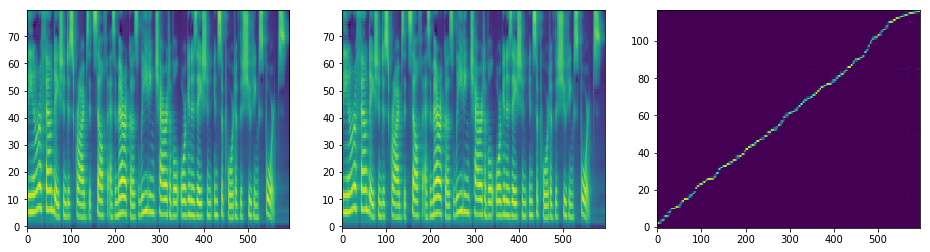

In [19]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [20]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [21]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
res = ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

In [22]:
res

In [25]:
import soundfile as sf

sf.write( 'test.wav', audio_denoised.cpu().numpy().ravel().astype("float64"), samplerate=hparams.sampling_rate)

In [29]:
all_texts = ['The N R A Foundation describes itself as “America’s leading charitable organization in support of the shooting sports.',
'Each year, the foundation—which is a nonpolitical arm of the National Rifle Association, and can accept tax-deductible contributions—takes in tens of millions of dollars, mostly from small donors.',
"He didn’t want to sleep on the streets of a strange city, and didn’t have the money for a bus back to San Bernardino.",
 "He decided to turn himself in. The cops picked him up and drove him to a concrete building in downtown Houston—the local office for Child Protective Services.",
 "They had Kelvin wait in a conference room, where, a few hours later, a man in baggy khakis and thick-soled sneakers padded through the door. He looked about sixty, with ruddy cheeks, cotton-white hair, and glassy blue eyes.",
 "His face was kind and sad. His name was James Terence Keel, but he went by Terry.", 
 "In both cases, the Mueller report’s description of ten actions by President Trump that may have constituted obstruction of justice is central to their argument.",
"As a child, Halep was so shy that it was painful for her even to speak on the phone, but she forced herself to face the cameras and the scrutiny of the media, which grew more intense with each season."
 "Every day, she went to the gym to tend to her muscles, joints, and ligaments. When her friends went to parties, she went to sleep."]

In [30]:
for idx in range(len(all_texts)):
    text = all_texts[idx]
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    audio_denoised = denoiser(audio, strength=0.01)[:, 0]
    sf.write( './wav/SS_{}.wav'.format(idx), audio_denoised.cpu().numpy().ravel().astype("float64"), samplerate=hparams.sampling_rate)

Warning! Reached max decoder steps
Warning! Reached max decoder steps
Warning! Reached max decoder steps
